In [103]:
#Importing the modules I presume will be necessary:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [104]:
#Reading the data into the dataframe that automatically puts the date column into datetime format and set it as the index:
df = pd.read_csv('avocado.csv', parse_dates =['Date'], index_col='Date')

In [105]:
#Renaming columns to reflect the avocado size they represent:
df.rename(columns = {'4046':'4046 - S', '4225':'4225 - L', '4770':'4770 - XL'}, inplace=True)

In [106]:
df = df.drop(['Unnamed: 0'], axis=1)
df['revenue'] = df.AveragePrice * df['Total Volume']
df.head()

,AveragePrice,Total Volume,4046 - S,4225 - L,4770 - XL,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,revenue
Date,,,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,85434.7046
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,74083.9230
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,109944.8046
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,85311.5220
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,65330.6880


In [107]:
#Mapping the numerical month from the datetime index to a new column called 'month'
df['month'] = df.index.map(lambda x: x.month)

#Creating a dictionary for the seasonal quarters and using it to map the appellation into a new column.
quarters = {1:'Q1', 2:'Q1', 3:'Q1', 4:'Q2', 5:'Q2', 6:'Q2', 7:'Q3', 8:'Q3', 9:'Q3', 10:'Q4', 11:'Q4', 12:'Q4' }
#quarters = {1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 3, 8: 3, 9: 3, 10: 4, 11: 4, 12: 4 }
df['quarter'] = df['month'].map(quarters)

#months = {1:'M - 1', 2:'M - 2', 3:'M - 3', 4:'M - 4', 
#         5:'M - 5', 6:'M - 6', 7:'M - 7', 8:'M - 8', 
#          9:'M - 9', 10:'M - 10', 11:'M - 11', 12:'M - 12' }

#dfx['months'] = dfx['month'].map(months)

#Creating lists for dummy variables
#month_list = list(dfx.months.unique())
quarter_list = list(df.quarter.unique())
region_list = list(df.region.unique())
type_list = list(df.type.unique())

In [108]:
#Creating a copy of the previously read-in dataframe and sorting the original's index:
df = df.sort_index()
dfx = df.copy()


In [109]:
#Create dataframe of the California regions:

df_con = df[df.type == 'conventional']

df_cali = df_con[df_con.region == 'California']
df_LA = df_con[df_con.region == 'LosAngeles']
df_san_fran = df_con[df_con.region == 'SanFrancisco']
df_san_diego = df_con[df_con.region == 'SanDiego']
df_sacramento = df_con[df_con.region == 'Sacramento']


### CALIFORNIA

Text(0.5,1,'Correlation Heat Map for Avocados')

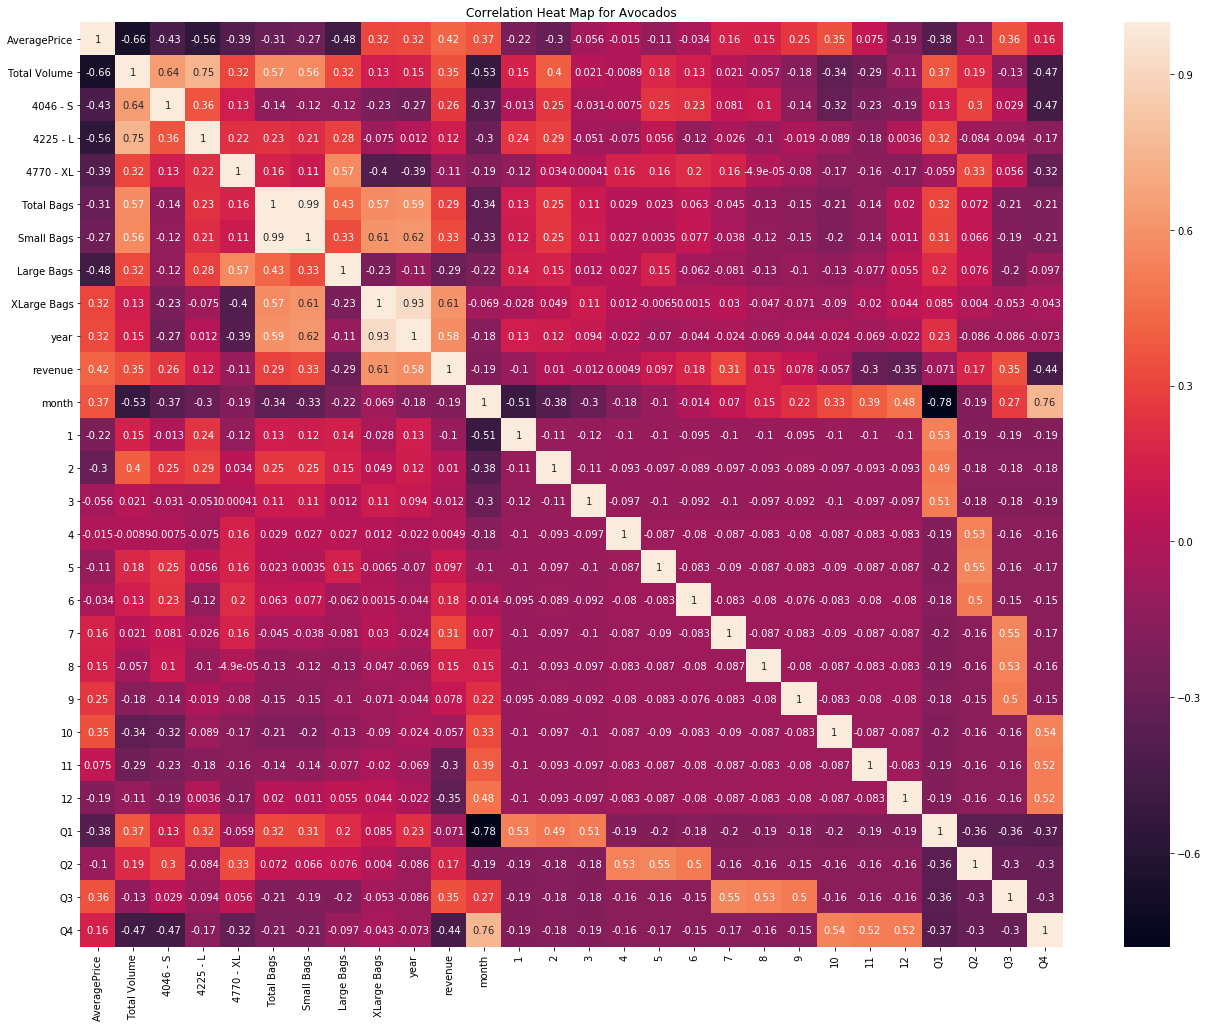

In [110]:
dummy_quarter = pd.get_dummies(df_cali['quarter'])
dummy_month = pd.get_dummies(df_cali['month'])
df_cali = pd.concat([df_cali, dummy_month, dummy_quarter], axis=1)
corr_matrix_cali = df_cali.corr() 

plt.figure(figsize=(22, 17))
sns.heatmap(corr_matrix_cali, xticklabels=corr_matrix_cali.columns, yticklabels=corr_matrix_cali.columns, annot=True)
plt.title('Correlation Heat Map for Avocados')


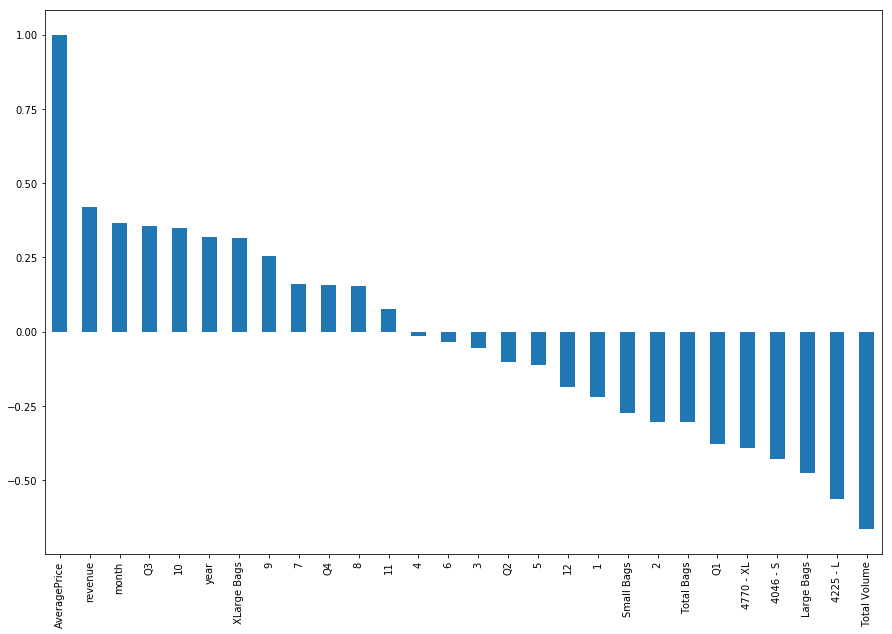

In [111]:
plt.figure(figsize=(15, 10))
corr_matrix_cali.AveragePrice.sort_values(ascending=False).plot(kind='bar')
#corr_matrix_cali.AveragePrice.plot(kind='bar')

In [112]:
df_cali.drop(['type'], axis=1, inplace=True)
df_cali.drop(['region'], axis=1, inplace=True)
df_cali.drop(['quarter'], axis=1, inplace=True)
df_cali = df_cali.rename(columns = {'AveragePrice':'AveragePriceCali'})


In [113]:
testx = df_cali.columns.to_list()
droplist = ['AveragePriceCali', 'month', 3, 4, 5, 6, 7, 8, 11, 12, 'Q2', 'Q4']

for i in range(len(droplist)):
    if droplist[i] in testx:
        testx.remove(droplist[i])

#Modeling. 
y = df_cali[(df_cali.columns[0])]
x = df_cali[testx]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print_model = model.summary()
cali_forecast = model.predict()
print(print_model)

rmse_cali = rmse(y, cali_forecast)
print('\nMean Square Error = ' + str(rmse_cali**2))


                            OLS Regression Results                            
Dep. Variable:       AveragePriceCali   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     177.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.77e-88
Time:                        17:28:54   Log-Likelihood:                 255.30
No. Observations:                 169   AIC:                            -478.6
Df Residuals:                     153   BIC:                            -428.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -155.9721     33.940     -4.596   

C:\Users\Typhonicus\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


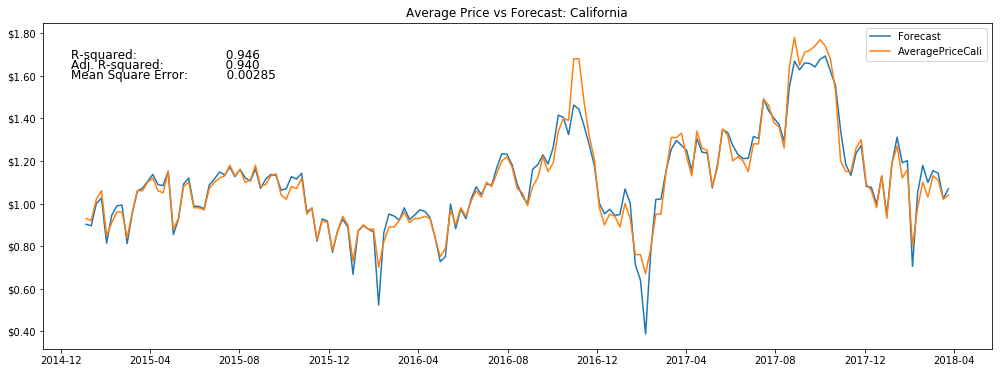

In [140]:
#df_cali['Forecast'] = pd.Series(cali_forecast)
df_cali['Forecast'] = cali_forecast

fig, ax = plt.subplots(figsize=(17,6))
#ax.figure()
plt.title('Average Price vs Forecast: California')
ax.plot(df_cali.index, df_cali.Forecast)
ax.plot(df_cali.index, df_cali.AveragePriceCali)
#ax.grid()

plt.text(0.03, 0.9, 'R-squared:                       0.946',
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='center', 
         transform=ax.transAxes)

plt.text(0.03, 0.87, 'Adj. R-squared:                0.940',
        fontsize=12,
        horizontalalignment='left',
        verticalalignment='center',
        transform=ax.transAxes)

plt.text(0.03, 0.84, 'Mean Square Error:          ' + "{:.5f}".format(rmse_cali**2),
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='center', 
         transform=ax.transAxes)



import matplotlib.ticker as mtick
dollar_format = '$%.2f'
ticks = mtick.FormatStrFormatter(dollar_format)
ax.yaxis.set_major_formatter(ticks)

ax.legend()


In [139]:
df_cali.head(50)

,AveragePriceCali,Total Volume,4046 - S,4225 - L,4770 - XL,Total Bags,Small Bags,Large Bags,XLarge Bags,year,...,8,9,10,11,12,Q1,Q2,Q3,Q4,Forecast
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-04,0.93,5777334.90,2843648.26,2267755.26,137479.64,528451.74,477193.38,47882.56,3375.80,2015,...,0,0,0,0,0,1,0,0,0,NaN
2015-01-11,0.92,6024932.34,2889591.29,2485720.10,103573.42,546047.53,510560.41,31874.03,3613.09,2015,...,0,0,0,0,0,1,0,0,0,NaN
2015-01-18,1.02,5570915.26,2780859.66,2108450.36,121614.31,559990.93,520299.26,36501.18,3190.49,2015,...,0,0,0,0,0,1,0,0,0,NaN
2015-01-25,1.06,4929884.26,2380955.61,1827783.28,150535.50,570609.87,521004.15,46809.48,2796.24,2015,...,0,0,0,0,0,1,0,0,0,NaN
2015-02-01,0.85,9032180.67,4794142.14,3460743.80,177145.49,600149.24,556205.20,41203.20,2740.84,2015,...,0,0,0,0,0,1,0,0,0,NaN
2015-02-08,0.91,5871224.58,2908845.38,2200393.89,149458.93,612526.38,553682.71,56311.08,2532.59,2015,...,0,0,0,0,0,1,0,0,0,NaN
2015-02-15,0.96,5699944.93,3315163.60,1620462.13,169907.54,594411.66,544990.68,47017.93,2403.05,2015,...,0,0,0,0,0,1,0,0,0,NaN
2015-02-22,0.96,5951871.32,3210177.22,1933699.49,172675.88,635318.73,596184.90,36940.51,2193.32,2015,...,0,0,0,0,0,1,0,0,0,NaN
2015-03-01,0.84,6700134.25,3516551.29,2460932.41,170580.54,552070.01,515386.40,34845.51,1838.10,2015,...,0,0,0,0,0,1,0,0,0,NaN


### LOS ANGELES

Text(0.5,1,'Correlation Heat Map for Avocados')

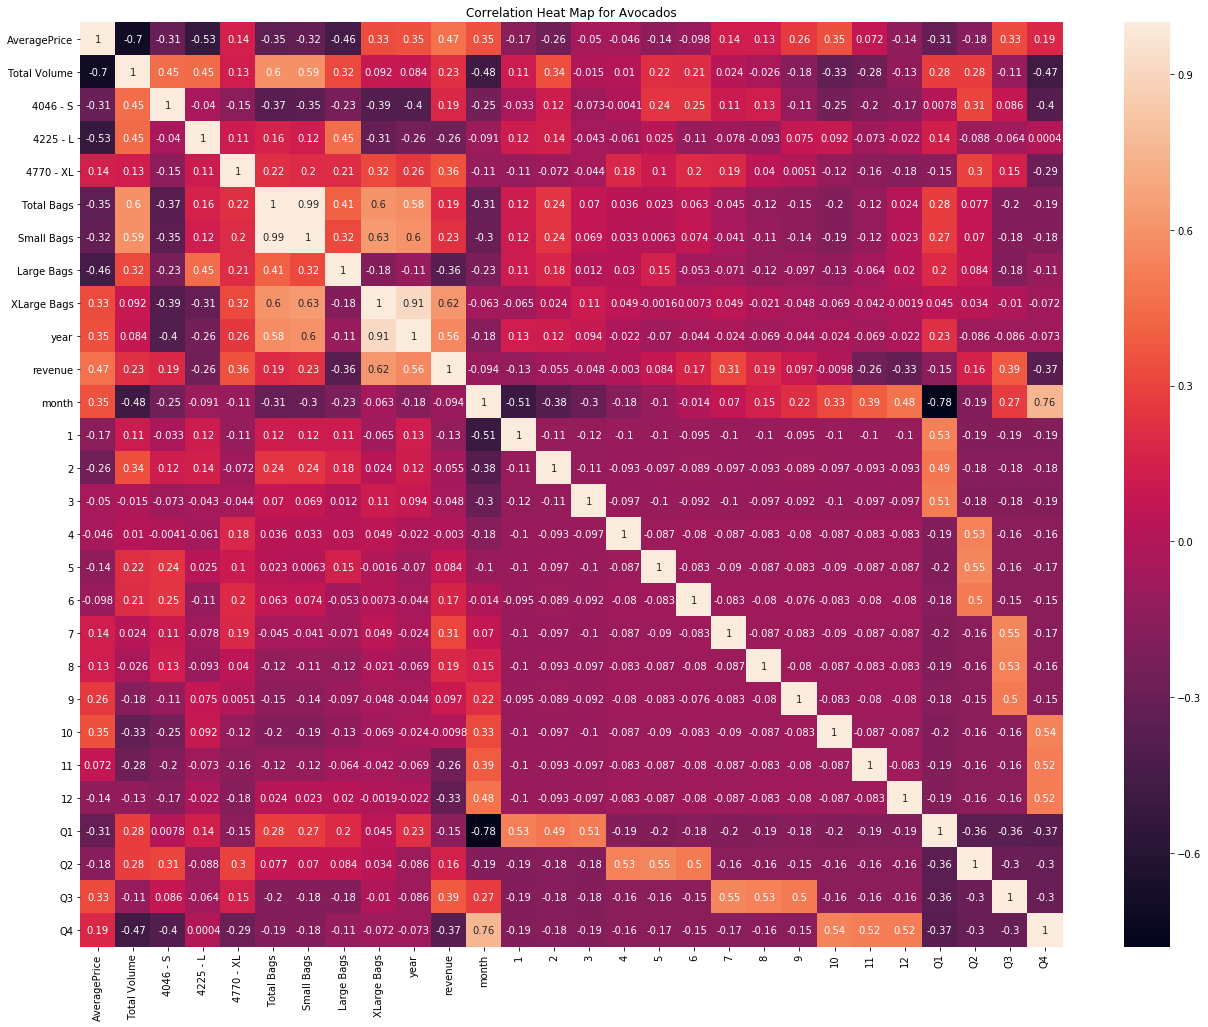

In [115]:
dummy_quarter = pd.get_dummies(df_LA['quarter'])
dummy_month = pd.get_dummies(df_LA['month'])
df_LA = pd.concat([df_LA, dummy_month, dummy_quarter], axis=1)
corr_matrix_LA = df_LA.corr() 

plt.figure(figsize=(22, 17))
sns.heatmap(corr_matrix_LA, xticklabels=corr_matrix_LA.columns, yticklabels=corr_matrix_LA.columns, annot=True)
plt.title('Correlation Heat Map for Avocados')

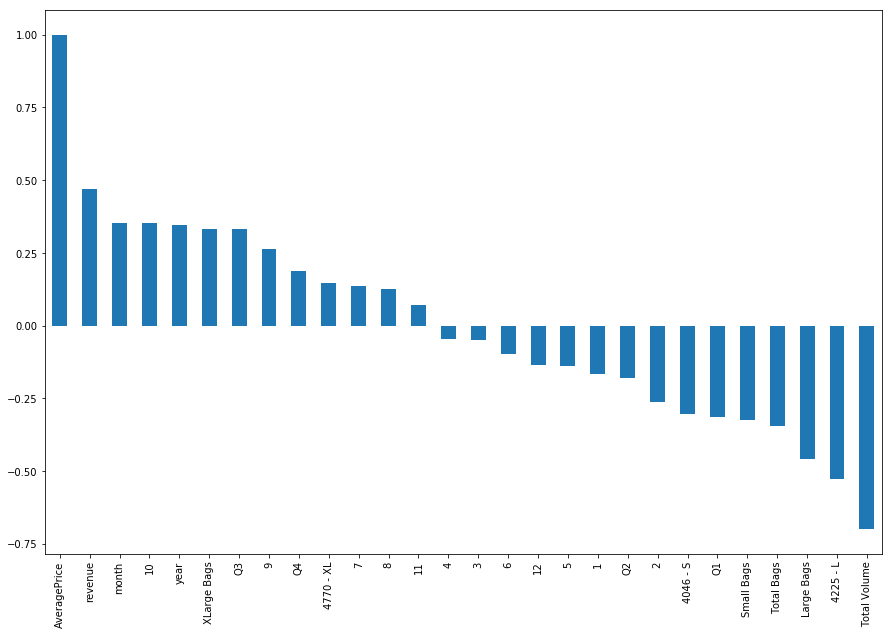

In [116]:
plt.figure(figsize=(15, 10))
corr_matrix_LA.AveragePrice.sort_values(ascending=False).plot(kind='bar')
#corr_matrix_LA.AveragePrice.plot(kind='bar')

In [117]:
df_LA.drop(['type'], axis=1, inplace=True)
df_LA.drop(['region'], axis=1, inplace=True)
df_LA.drop(['quarter'], axis=1, inplace=True)
df_LA = df_LA.rename(columns = {'AveragePrice':'AveragePriceLA'})

In [118]:
testx = df_LA.columns.to_list()
droplist = ['4770 - XL','AveragePriceLA', 'month', 1, 3, 4, 5, 6, 7, 8, 11, 12]


for i in range(len(droplist)):
    if droplist[i] in testx:
        testx.remove(droplist[i])

#Modeling. 
y = df_LA[(df_LA.columns[0])]
x = df_LA[testx]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print_model = model.summary()
LA_forecast = model.predict()
print(print_model)

rmseLA = rmse(y, LA_forecast)
print('\nMean Square Error = ' + str(rmseLA**2))


                            OLS Regression Results                            
Dep. Variable:         AveragePriceLA   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     149.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.94e-83
Time:                        17:28:58   Log-Likelihood:                 231.23
No. Observations:                 169   AIC:                            -430.5
Df Residuals:                     153   BIC:                            -380.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -93.8359     25.285     -3.711   

C:\Users\Typhonicus\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


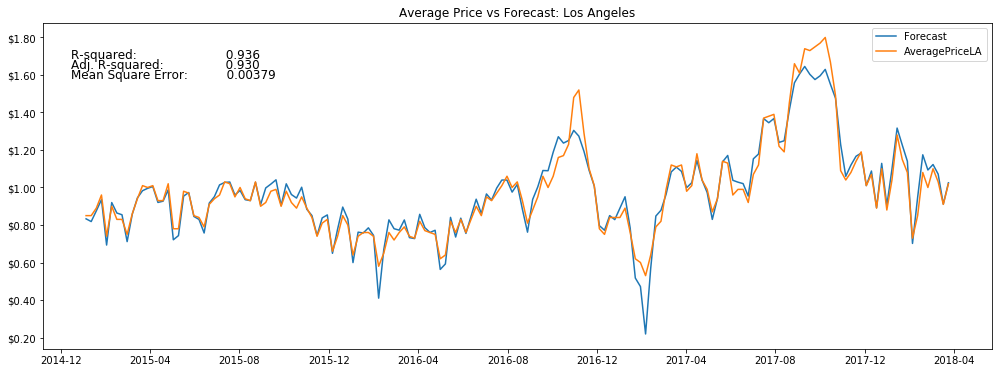

In [141]:
df_LA['Forecast'] = LA_forecast

fig, ax = plt.subplots(figsize=(17,6))
#ax.figure()
plt.title('Average Price vs Forecast: Los Angeles')
ax.plot(df_LA.index, df_LA.Forecast)
ax.plot(df_LA.index, df_LA.AveragePriceLA)
#ax.grid()

plt.text(0.03, 0.9, 'R-squared:                       0.936',
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='center', 
         transform=ax.transAxes)

plt.text(0.03, 0.87, 'Adj. R-squared:                0.930',
        fontsize=12,
        horizontalalignment='left',
        verticalalignment='center',
        transform=ax.transAxes)

plt.text(0.03, 0.84, 'Mean Square Error:          ' + "{:.5f}".format(rmseLA**2),
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='center', 
         transform=ax.transAxes)



import matplotlib.ticker as mtick
dollar_format = '$%.2f'
ticks = mtick.FormatStrFormatter(dollar_format)
ax.yaxis.set_major_formatter(ticks)

ax.legend()


### SAN FRANCISCO

Text(0.5,1,'Correlation Heat Map for Avocados')

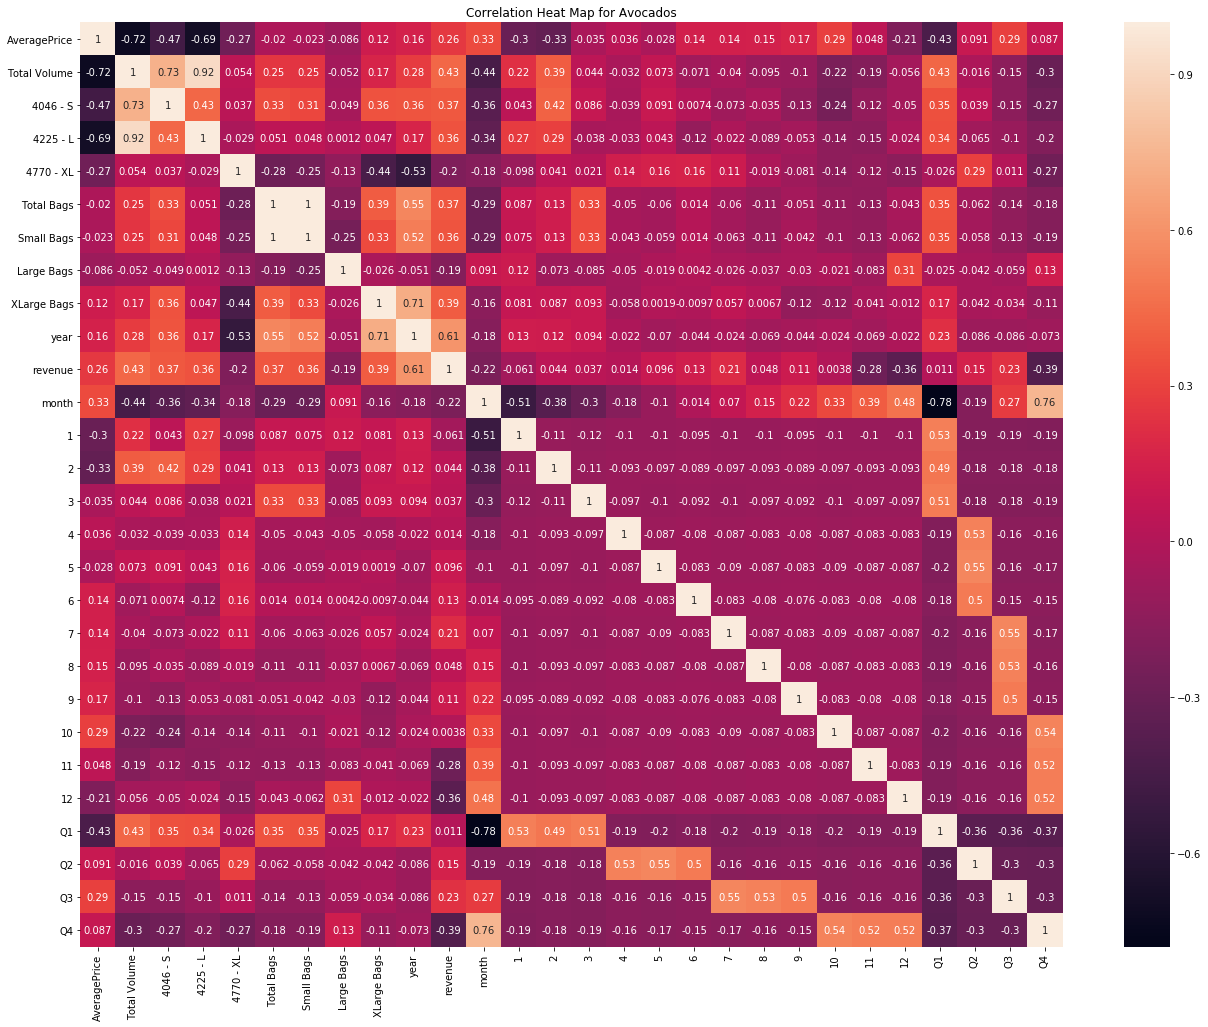

In [120]:
dummy_quarter = pd.get_dummies(df_san_fran['quarter'])
dummy_month = pd.get_dummies(df_san_fran['month'])
df_san_fran = pd.concat([df_san_fran, dummy_month, dummy_quarter], axis=1)
corr_matrix_san_fran = df_san_fran.corr() 

plt.figure(figsize=(22, 17))
sns.heatmap(corr_matrix_san_fran, xticklabels=corr_matrix_san_fran.columns, yticklabels=corr_matrix_san_fran.columns, annot=True)
plt.title('Correlation Heat Map for Avocados')


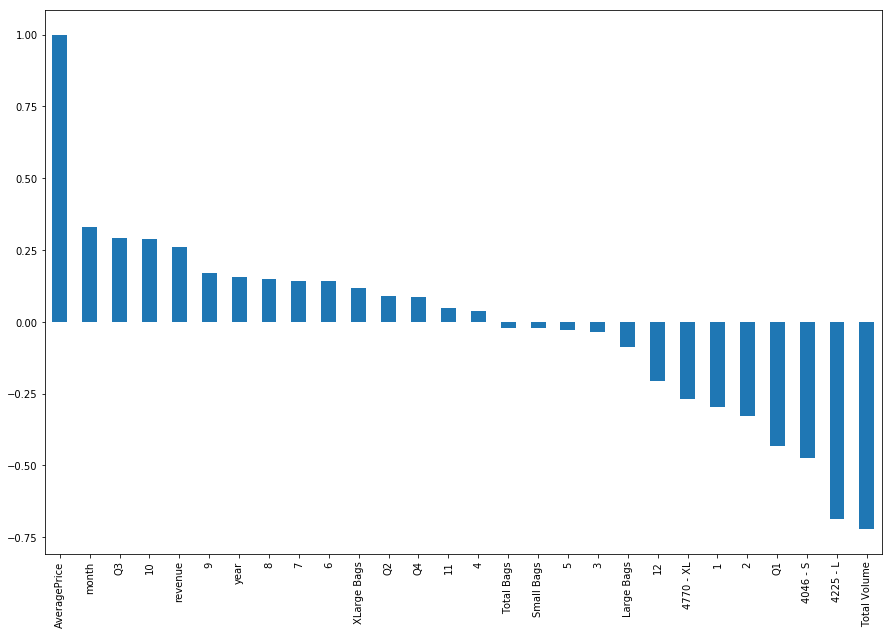

In [121]:
plt.figure(figsize=(15, 10))
corr_matrix_san_fran.AveragePrice.sort_values(ascending=False).plot(kind='bar')
#corr_matrix_san_fran.AveragePrice.plot(kind='bar')


In [122]:
df_san_fran.drop(['type'], axis=1, inplace=True)
df_san_fran.drop(['region'], axis=1, inplace=True)
df_san_fran.drop(['quarter'], axis=1, inplace=True)
df_san_fran = df_san_fran.rename(columns = {'AveragePrice':'AveragePriceSanFran'})

In [123]:
testx = df_san_fran.columns.to_list()
droplist = ['Total Bags','Small Bags', 'Large Bags', 'XLarge Bags', 'year', 'AveragePriceSanFran', 'month', 3, 4, 5, 6, 7, 8, 9, 11, 'Q2', 'Q4']

for i in range(len(droplist)):
    if droplist[i] in testx:
        testx.remove(droplist[i])

#Modeling. 
y = df_san_fran[(df_san_fran.columns[0])]
x = df_san_fran[testx]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print_model = model.summary()
san_fran_forecast = model.predict()
print(print_model)

rmse_san_fran = rmse(y, san_fran_forecast)
print('\nMean Square Error = ' + str(rmse_san_fran**2))


                             OLS Regression Results                            
Dep. Variable:     AveragePriceSanFran   R-squared:                       0.936
Model:                             OLS   Adj. R-squared:                  0.932
Method:                  Least Squares   F-statistic:                     210.1
Date:                 Tue, 28 Apr 2020   Prob (F-statistic):           6.76e-88
Time:                         17:29:03   Log-Likelihood:                 203.42
No. Observations:                  169   AIC:                            -382.8
Df Residuals:                      157   BIC:                            -345.3
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.2779      0.053    

C:\Users\Typhonicus\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


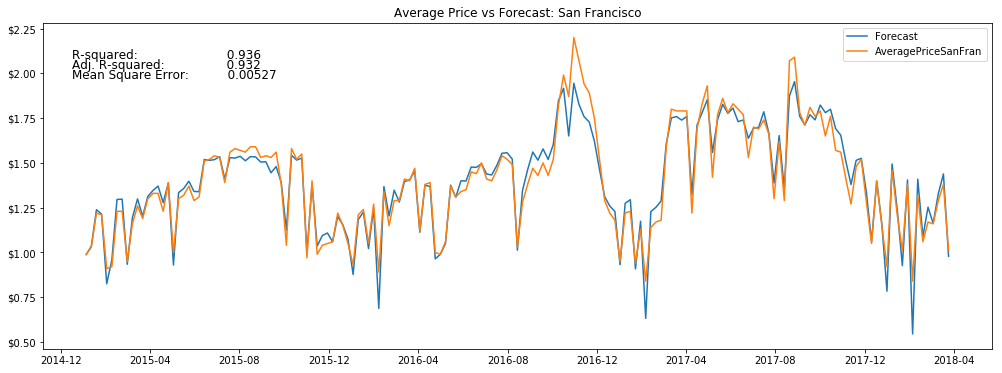

In [142]:
df_san_fran['Forecast'] = san_fran_forecast

fig, ax = plt.subplots(figsize=(17,6))
#ax.figure()
plt.title('Average Price vs Forecast: San Francisco')
ax.plot(df_san_fran.index, df_san_fran.Forecast)
ax.plot(df_san_fran.index, df_san_fran.AveragePriceSanFran)
#ax.grid()

plt.text(0.03, 0.9, 'R-squared:                       0.936',
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='center', 
         transform=ax.transAxes)

plt.text(0.03, 0.87, 'Adj. R-squared:                0.932',
        fontsize=12,
        horizontalalignment='left',
        verticalalignment='center',
        transform=ax.transAxes)

plt.text(0.03, 0.84, 'Mean Square Error:          '  + "{:.5f}".format(rmse_san_fran**2),
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='center', 
         transform=ax.transAxes)



import matplotlib.ticker as mtick
dollar_format = '$%.2f'
ticks = mtick.FormatStrFormatter(dollar_format)
ax.yaxis.set_major_formatter(ticks)

ax.legend()


### SAN DIEGO

Text(0.5,1,'Correlation Heat Map for Avocados')

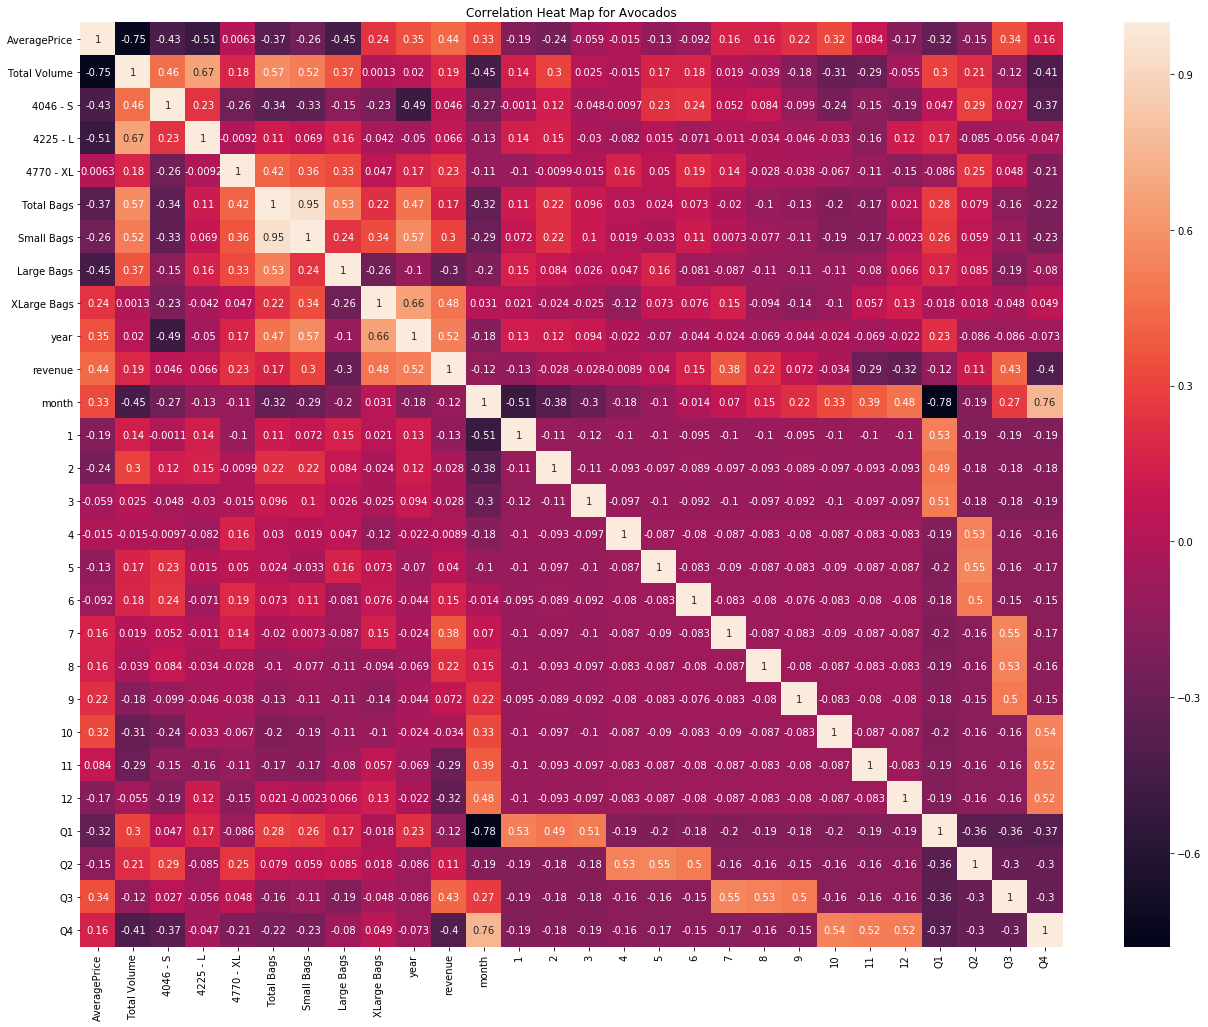

In [125]:
dummy_quarter = pd.get_dummies(df_san_diego['quarter'])
dummy_month = pd.get_dummies(df_san_diego['month'])
df_san_diego = pd.concat([df_san_diego, dummy_month, dummy_quarter], axis=1)
corr_matrix_san_diego = df_san_diego.corr() 

plt.figure(figsize=(22, 17))
sns.heatmap(corr_matrix_san_diego, xticklabels=corr_matrix_san_diego.columns, yticklabels=corr_matrix_san_diego.columns, annot=True)
plt.title('Correlation Heat Map for Avocados')


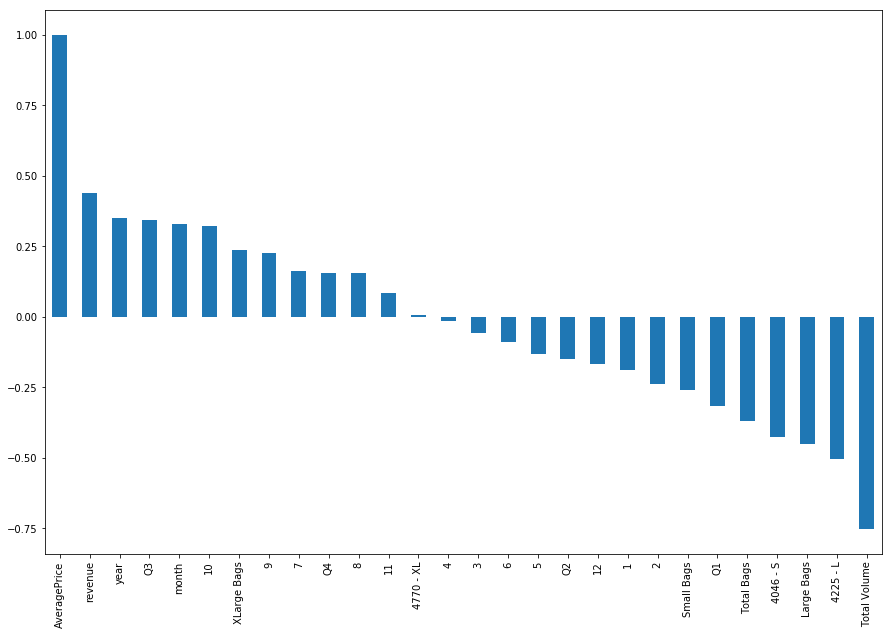

In [126]:
plt.figure(figsize=(15, 10))
corr_matrix_san_diego.AveragePrice.sort_values(ascending=False).plot(kind='bar')
#corr_matrix_san_diego.AveragePrice.plot(kind='bar')


In [127]:
df_san_diego.drop(['type'], axis=1, inplace=True)
df_san_diego.drop(['region'], axis=1, inplace=True)
df_san_diego.drop(['quarter'], axis=1, inplace=True)
df_san_diego = df_san_diego.rename(columns = {'AveragePrice':'AveragePriceSanDiego'})


In [128]:
testx = df_san_diego.columns.to_list()
droplist = ['XLarge Bags', 'year', 'AveragePriceSanDiego', 'month', 1, 3, 4, 5, 6, 7, 8, 11, 12, 'Q2', 'Q4']

for i in range(len(droplist)):
    if droplist[i] in testx:
        testx.remove(droplist[i])

#Modeling. 
y = df_san_diego[(df_san_diego.columns[0])]
x = df_san_diego[testx]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print_model = model.summary()
san_diego_forecast = model.predict()
print(print_model)

rmse_san_diego = rmse(y, san_diego_forecast)
print('\nMean Square Error = ' + str(rmse_san_diego**2))


                             OLS Regression Results                             
Dep. Variable:     AveragePriceSanDiego   R-squared:                       0.937
Model:                              OLS   Adj. R-squared:                  0.931
Method:                   Least Squares   F-statistic:                     176.4
Date:                  Tue, 28 Apr 2020   Prob (F-statistic):           9.68e-86
Time:                          17:29:08   Log-Likelihood:                 229.13
No. Observations:                   169   AIC:                            -430.3
Df Residuals:                       155   BIC:                            -386.4
Df Model:                            13                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.9239     

C:\Users\Typhonicus\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


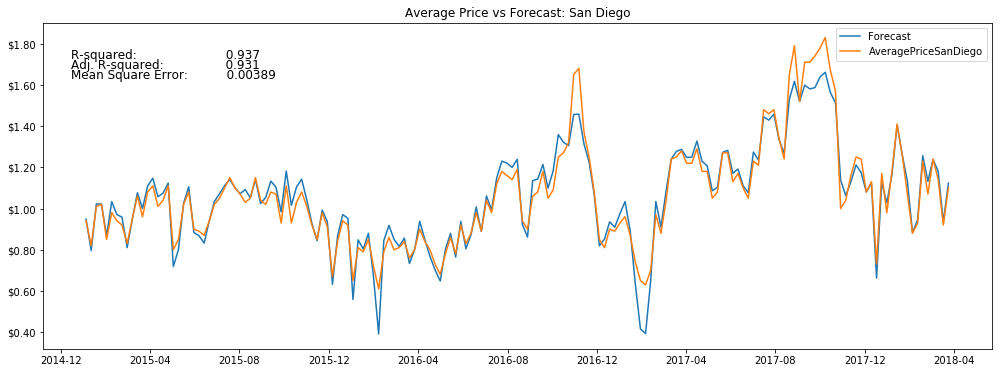

In [143]:
df_san_diego['Forecast'] = san_diego_forecast

fig, ax = plt.subplots(figsize=(17,6))
#ax.figure()
plt.title('Average Price vs Forecast: San Diego')
ax.plot(df_san_diego.index, df_san_diego.Forecast)
ax.plot(df_san_diego.index, df_san_diego.AveragePriceSanDiego)
#ax.grid()

plt.text(0.03, 0.9, 'R-squared:                       0.937',
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='center', 
         transform=ax.transAxes)

plt.text(0.03, 0.87, 'Adj. R-squared:                0.931',
        fontsize=12,
        horizontalalignment='left',
        verticalalignment='center',
        transform=ax.transAxes)

plt.text(0.03, 0.84, 'Mean Square Error:          ' + "{:.5f}".format(rmse_san_diego**2),
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='center', 
         transform=ax.transAxes)



import matplotlib.ticker as mtick
dollar_format = '$%.2f'
ticks = mtick.FormatStrFormatter(dollar_format)
ax.yaxis.set_major_formatter(ticks)

ax.legend()


### SACRAMENTO

Text(0.5,1,'Correlation Heat Map for Avocados')

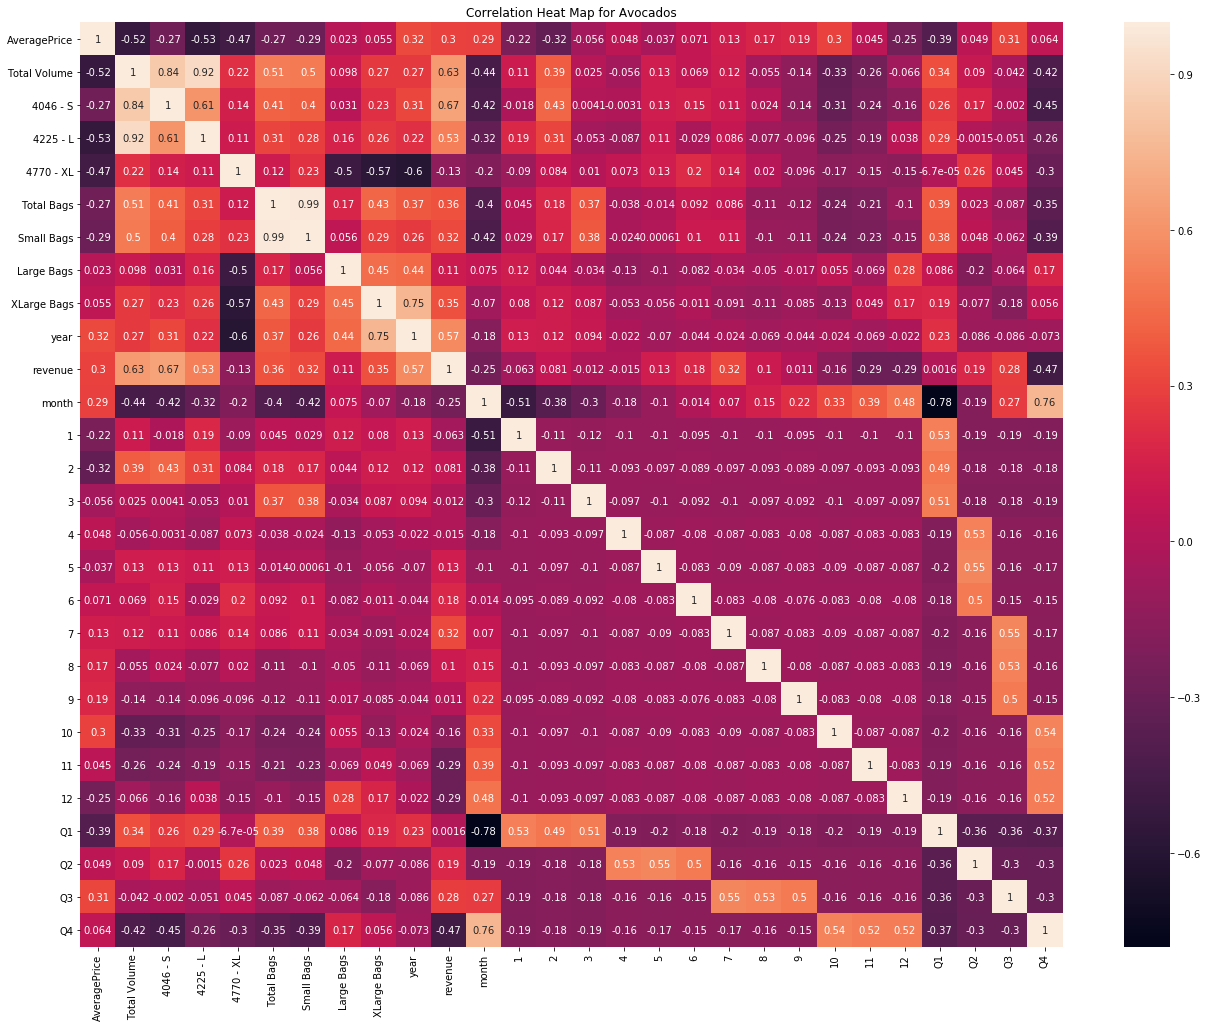

In [130]:
dummy_quarter = pd.get_dummies(df_sacramento['quarter'])
dummy_month = pd.get_dummies(df_sacramento['month'])
df_sacramento = pd.concat([df_sacramento, dummy_month, dummy_quarter], axis=1)
corr_matrix_sacramento = df_sacramento.corr() 

plt.figure(figsize=(22, 17))
sns.heatmap(corr_matrix_sacramento, xticklabels=corr_matrix_sacramento.columns, yticklabels=corr_matrix_sacramento.columns, annot=True)
plt.title('Correlation Heat Map for Avocados')


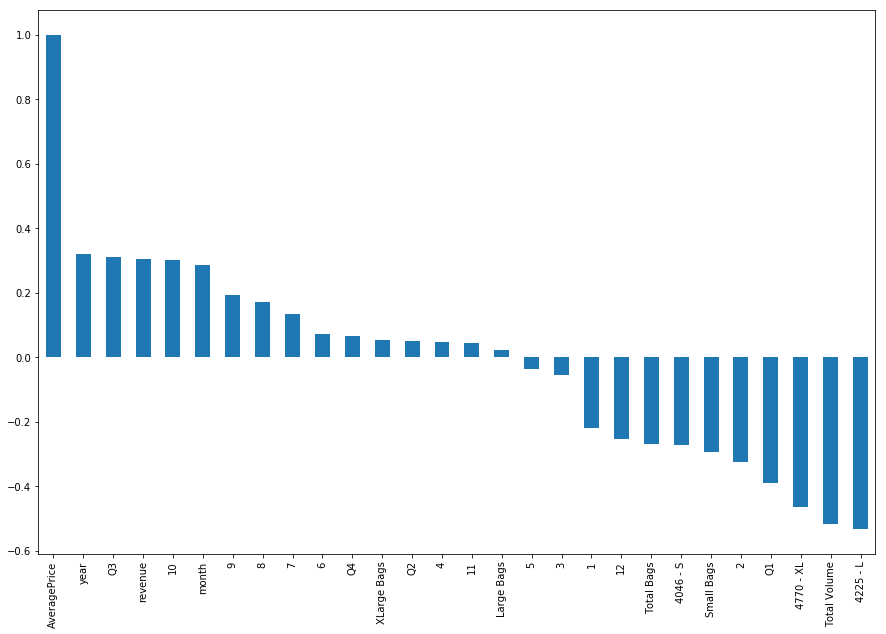

In [131]:
plt.figure(figsize=(15, 10))
corr_matrix_sacramento.AveragePrice.sort_values(ascending=False).plot(kind='bar')
#corr_matrix_sacramento.AveragePrice.plot(kind='bar')


In [132]:
df_sacramento.drop(['type'], axis=1, inplace=True)
df_sacramento.drop(['region'], axis=1, inplace=True)
df_sacramento.drop(['quarter'], axis=1, inplace=True)
df_sacramento = df_sacramento.rename(columns = {'AveragePrice':'AveragePriceSacramento'})


In [133]:
testx = df_sacramento.columns.to_list()
droplist = ['Large Bags', 'XLarge Bags', 'year', 'AveragePriceSacramento', 'month', 3, 4, 5, 6, 7, 8, 9, 11, 'Q2', 'Q4']

for i in range(len(droplist)):
    if droplist[i] in testx:
        testx.remove(droplist[i])

#Modeling. 
y = df_sacramento[(df_sacramento.columns[0])]
x = df_sacramento[testx]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print_model = model.summary()
sacramento_forecast = model.predict()
print(print_model)

rmse_sacramento = rmse(y, sacramento_forecast)
print('\nMean Square Error = ' + str(rmse_sacramento**2))


                              OLS Regression Results                              
Dep. Variable:     AveragePriceSacramento   R-squared:                       0.949
Model:                                OLS   Adj. R-squared:                  0.945
Method:                     Least Squares   F-statistic:                     222.5
Date:                    Tue, 28 Apr 2020   Prob (F-statistic):           4.42e-93
Time:                            17:29:12   Log-Likelihood:                 270.61
No. Observations:                     169   AIC:                            -513.2
Df Residuals:                         155   BIC:                            -469.4
Df Model:                              13                                         
Covariance Type:                nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const   

C:\Users\Typhonicus\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


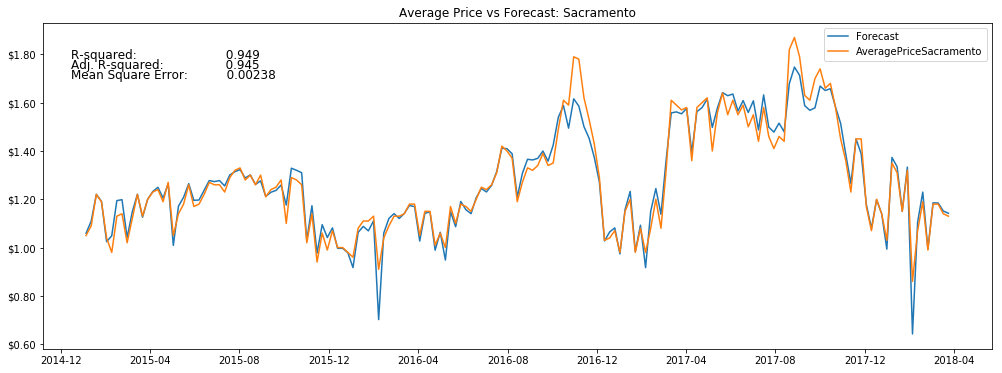

In [144]:
df_sacramento['Forecast'] = sacramento_forecast

fig, ax = plt.subplots(figsize=(17,6))
#ax.figure()
plt.title('Average Price vs Forecast: Sacramento')
ax.plot(df_sacramento.index, df_sacramento.Forecast)
ax.plot(df_sacramento.index, df_sacramento.AveragePriceSacramento)
#ax.grid()

plt.text(0.03, 0.9, 'R-squared:                       0.949',
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='center', 
         transform=ax.transAxes)

plt.text(0.03, 0.87, 'Adj. R-squared:                0.945',
        fontsize=12,
        horizontalalignment='left',
        verticalalignment='center',
        transform=ax.transAxes)

plt.text(0.03, 0.84, 'Mean Square Error:          ' + "{:.5f}".format(rmse_sacramento**2),
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='center', 
         transform=ax.transAxes)

plt.text(0.03, 0.84, 'Mean Square Error:          ' + "{:.5f}".format(rmse_sacramento**2),
         fontsize=12,
         horizontalalignment='left',
         verticalalignment='center', 
         transform=ax.transAxes)

import matplotlib.ticker as mtick
dollar_format = '$%.2f'
ticks = mtick.FormatStrFormatter(dollar_format)
ax.yaxis.set_major_formatter(ticks)

ax.legend()


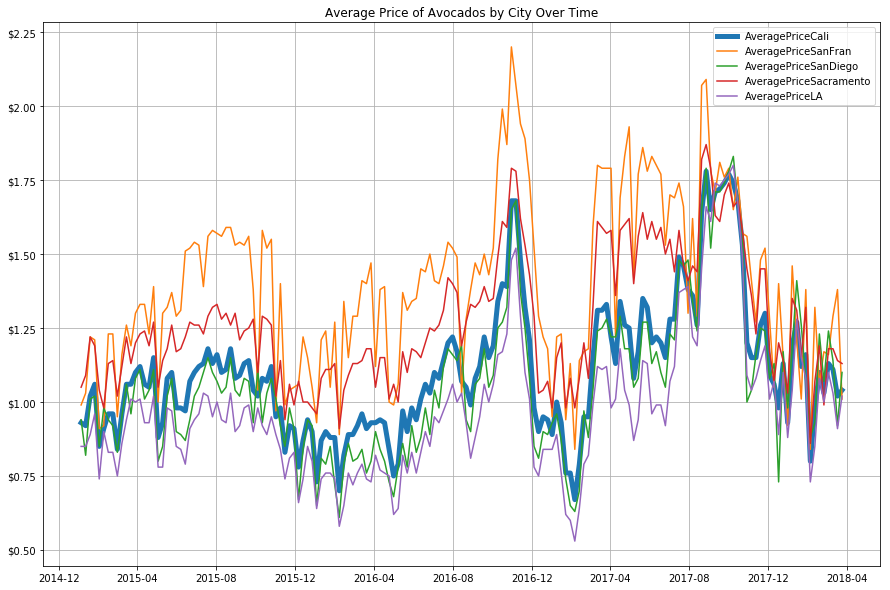

In [149]:
fig, ax = plt.subplots(figsize=(15,10))
#ax.figure()
plt.title('Average Price of Avocados by City Over Time')
ax.plot(df_cali.index, df_cali.AveragePriceCali, linewidth=5)
ax.plot(df_san_fran.index, df_san_fran.AveragePriceSanFran)
ax.plot(df_san_diego.index, df_san_diego.AveragePriceSanDiego)
ax.plot(df_sacramento.index, df_sacramento.AveragePriceSacramento)
ax.plot(df_LA.index, df_LA.AveragePriceLA)
ax.grid()
#plt.plot(df_plains.index, forecast_plains)

import matplotlib.ticker as mtick
dollar_format = '$%.2f'
ticks = mtick.FormatStrFormatter(dollar_format)
ax.yaxis.set_major_formatter(ticks)

ax.legend()

In [ ]:
dir()